# Human Segmentation using UNET

## Importing all the necessary libraries

In [ ]:
import os
import cv2
import numpy as np
from glob import glob
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import matplotlib.image as img

### Seeding our environment
Seeding ensures we get the same results when we run our training process again, allowing for better reproducibility.

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

### Setting up Hyperparameters
Hyperparameters function as critical control variables that govern the learning algorithm. Effective selection of these parameters optimizes the model's capacity to learn from data and generate accurate predictions

In [ ]:
batch_size = 8
learning_rate = 1e-4  # 0.0001
epochs = 15

model_path = os.path.join("models", "unet-model.keras")
csv_log_path = os.path.join("models", "log.csv")

## Loading Data

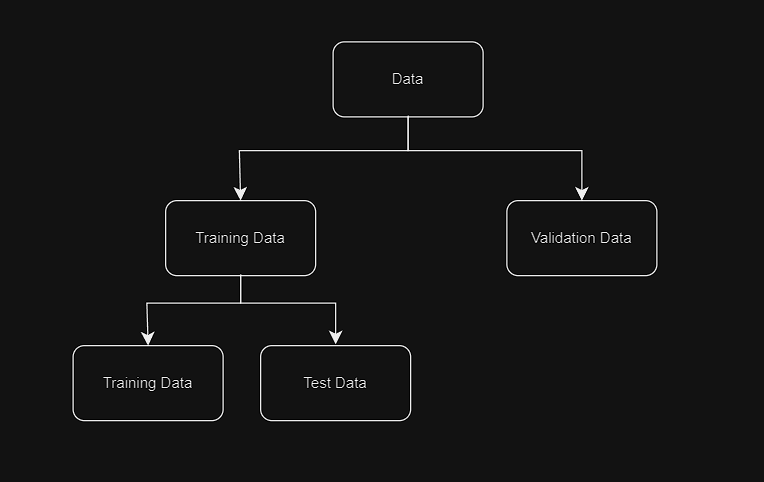

First, we loaded our data. Then, we divided it into two parts: training and validation. Later, we further divided the training data into training and test sets. Finally, we printed the number of samples in each set (training, validation, and testing).

In [ ]:
def load_dataset(path, split = 0.2):
    images = sorted(glob(os.path.join(path, "images/", "*.png")))
    masks = sorted(glob(os.path.join(path, "masks/", "*.png")))

    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

dataset_path = ''
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)
print(f'Train: {len(train_x)} - {len(train_y)}')
print(f'Valid: {len(valid_x)} - {len(valid_y)}')
print(f'Test: {len(test_x)} - {len(test_y)}')

Train: 1601 - 1601
Valid: 533 - 533
Test: 533 - 533


## Data Preprocessing

### Normalizing the loaded data

Why we need to normalize our data?

Images typically use the RGB color channel, where each pixel's value ranges from 0 to 255. This wide range can hinder a model's training process. Normalization addresses this by scaling the pixel intensities to a smaller range, often between 0 and 1. This improves the training efficiency and performance of the model.


Here, we define two helper functions to facilitate data pre-processing:
- read_image(): This function loads the original image and applies normalization to its pixel.
- read_mask(): This function loads the mask corresponding to the loaded image and performs normalization on its values.

In [ ]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (256, 256))
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (256, 256))
    x = x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

### Creating batches for our respective datasets

Our datasets (training, testing, and validation) are not structured as batches. The model typically cannot process the entire dataset at once. Instead, it process data in smaller, manageable portions called batches. Therefore, converting our data into batches is crucial for efficient training.

In [ ]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([256, 256, 3])
    y.set_shape([256, 256, 1])

    return x, y

def tf_dataset(x, y, batch = 8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(5)
    return dataset

In [ ]:
train_dataset = tf_dataset(train_x, train_y, batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch_size)

## Building the Model

<center>U-NET ARCHITECTURE</center>

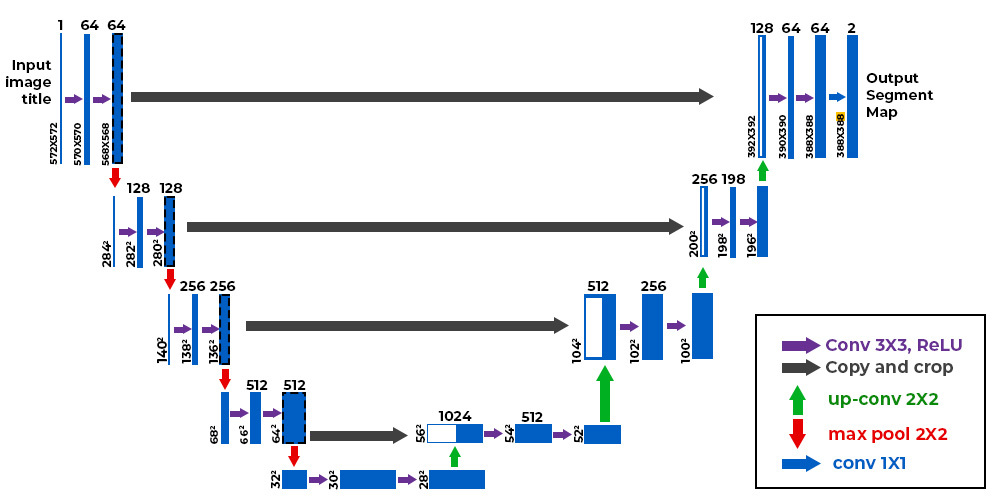

**Why use U-NET?**

U-Net's architecture is specifically designed for image segmentation tasks.  The combination of its contracting and expanding paths allows it to efficiently capture both high-level details and precise location information from images. This is particularly useful when dealing with limited datasets, as U-Net can leverage the information from high-resolution features even with fewer training examples. Finally, the skip connections within the network contribute to U-Net's ability to precisely localize objects and regions within an image, making it a powerful tool for accurate segmentation.

In [ ]:
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, CSVLogger

### Step 1: Defining the encoder block
This block consists of two 3×3 convolution layers followed by a ReLU activation layer and a 2×2 max pooling layer.


In [ ]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2,2))(x)
    return x, p

### Step 2: Defining the decoder block

It takes the feature map from the lower layer, upconverts it, crops and concatenates it with the encoder data of the same level, and then performs two 3×3 convolution layers followed by ReLU activation.

In [ ]:
def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 3, strides = 2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

### Step 3: Defining U-NET model

The model uses a contracting encoder pathway with four encoder blocks to capture contextual information. A bridge that connects to an expansive decoder pathway with four decoder blocks, allowing for precise localization. Finally, an output layer that generates the segmentation mask.

In [ ]:
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

## Compilation and Training of the Model

### Compiling and checking summary of the Model

We will define our model using the build_model function, specifying the input shape as a parameter. Once built, the model will be compiled using binary cross-entropy as the loss function and the Adam optimizer with a specified learning rate. Finally, we can call the model summary method to view its architecture details.

In [ ]:
input_shape = (256, 256, 3)
model = build_unet(input_shape)
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "UNET"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 34,536,897 (131.75 MB)

 Trainable params: 34,525,121 (131.70 MB)

 Non-trainable params: 11,776 (46.00 KB)

### Setting up Callbacks and Fitting data to the Model

Why use callbacks?

Callbacks are used to optimize the training process. They provide real-time monitoring of training metrics, allowing us to measure progress and identify potential problems. Model checkpointing regularly saves the model's state during training.

Callback used:
- ModelCheckpoint: It periodically saves the model's state during training, capturing the best performing model based on some chosen metric.
- CSVLogger: It logs training statistics (metrics like loss, accuracy) to a CSV file at specified intervals, allowing you to track and analyze the training progress over time.

Finally, after configuring the callbacks, we invoke the `model.fit` method to initiate the training process. This method takes the training and validation datasets, the number of epochs, and the configured callbacks as arguments.

In [ ]:
callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    CSVLogger(csv_log_path)
]

history = model.fit(
    train_dataset,
    epochs = epochs,
    validation_data = valid_dataset,
    callbacks = callbacks
)

Epoch 1/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 798ms/step - accuracy: 0.7376 - loss: 0.5217
Epoch 1: val_loss improved from inf to 0.48618, saving model to models/unet-model.keras
201/201 ━━━━━━━━━━━━━━━━━━━━ 276s 1s/step - accuracy: 0.7379 - loss: 0.5213 - val_accuracy: 0.7758 - val_loss: 0.4862
Epoch 2/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.8443 - loss: 0.3570
Epoch 2: val_loss did not improve from 0.48618
201/201 ━━━━━━━━━━━━━━━━━━━━ 222s 813ms/step - accuracy: 0.8443 - loss: 0.3569 - val_accuracy: 0.7179 - val_loss: 1.1401
Epoch 3/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - accuracy: 0.8673 - loss: 0.3078
Epoch 3: val_loss did not improve from 0.48618
201/201 ━━━━━━━━━━━━━━━━━━━━ 211s 856ms/step - accuracy: 0.8673 - loss: 0.3078 - val_accuracy: 0.7614 - val_loss: 0.8782
Epoch 4/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - accuracy: 0.8831 - loss: 0.2747
Epoch 4: val_loss did not improve from 0.48618
201/201 ━━━━━━━━━━━━━━━━━━━━ 170s 847ms/step - accuracy: 0.

## Evaluating the Model

### Loading Test data and Evaluating our Model

We first ensured our test data was formatted in batches. Then, we evaluated the model's performance on the test data using the `model.evaluate` method. This method takes the test dataset as input and returns metrics like loss and accuracy.

In [ ]:
test_dataset = tf_dataset(test_x, test_y, batch_size)

In [ ]:
model.evaluate(test_dataset)

67/67 ━━━━━━━━━━━━━━━━━━━━ 33s 494ms/step - accuracy: 0.9025 - loss: 0.2810


[0.2863549590110779, 0.9007251262664795]

The proposed model achieved an accuracy of **90%** on the evaluation task.

### Plotting training metrics

In [ ]:
epochs = range(len(history.history['accuracy']))
epochs

range(0, 15)

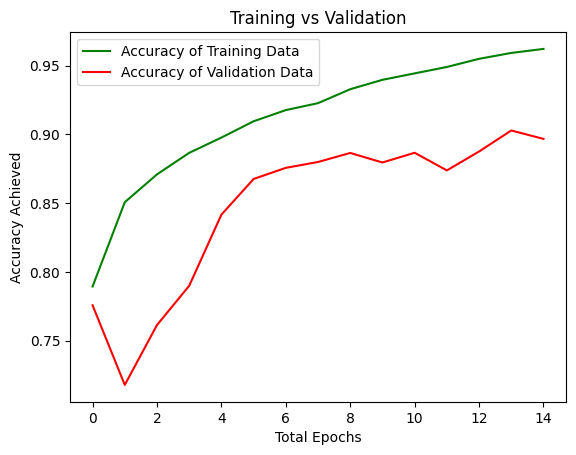

In [ ]:
plt.plot(epochs, history.history['accuracy'], 'green', label='Accuracy of Training Data')
plt.plot(epochs, history.history['val_accuracy'], 'red', label='Accuracy of Validation Data')
plt.xlabel("Total Epochs")
plt.ylabel("Accuracy Achieved")
plt.title("Training vs Validation")
plt.legend(loc='upper left')
plt.show()

## Testing the model with Random Images

To evaluate the model's segmentation capabilities, we made predictions on a subset of the test dataset, specifically the first 15 images. We then visualized the resulting segmentation masks to assess the model's performance.

In [ ]:
def save_results(image, predicted_image, save_image_path):
    predicted_image = np.expand_dims(predicted_image, axis=-1)
    predicted_image = np.concatenate([predicted_image, predicted_image, predicted_image], axis=-1)
    predicted_image = predicted_image * 255

    line = np.ones((256, 10, 3)) * 255

    cat_images = np.concatenate([image, line, predicted_image], axis=1)
    cv2.imwrite(save_image_path, cat_images)


i = 0
for x, y in zip(test_x, test_y):
    if i == 15: break

    name = x.split("images\\")[-1]

    image = cv2.imread(x, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (256, 256))
    x = image/255.0
    x = np.expand_dims(x, axis=0)

    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (256, 256))

    y_pred = model.predict(x, verbose=0)[0]
    y_pred = np.squeeze(y_pred, axis=-1)
    y_pred = y_pred >= 0.5
    y_pred = y_pred.astype(np.int32)

    save_predicted_path = os.path.join("results", name)
    save_results(image, y_pred, save_predicted_path)

    i += 1

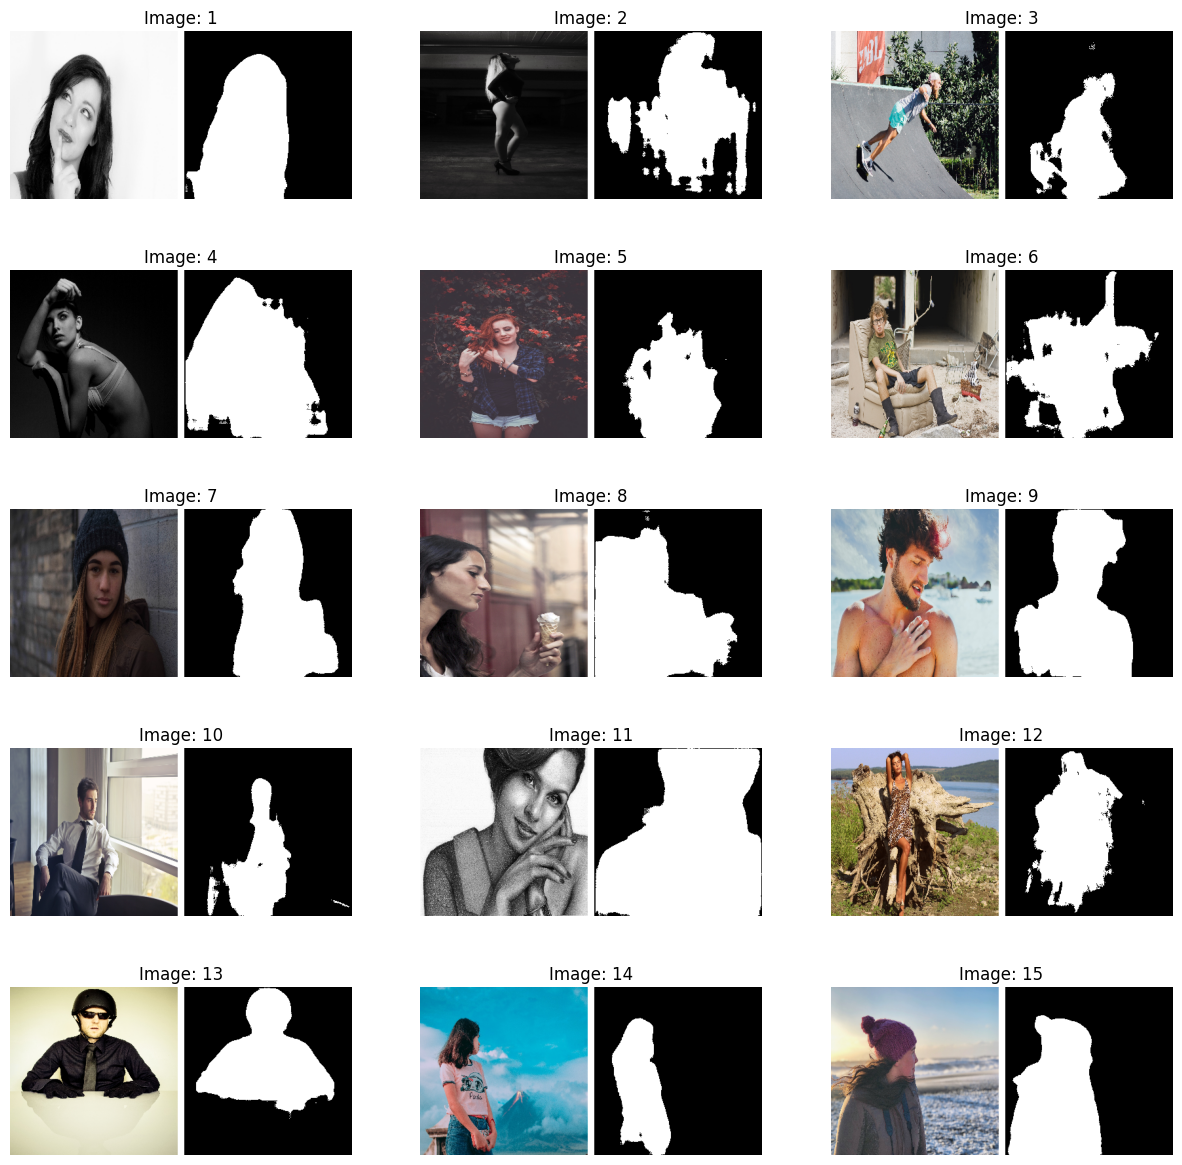

In [ ]:
plt.figure(figsize=[15, 15])
counter = 0
for i in os.listdir("/content/results"):
  if (i.split(".")[-1]) == "png":
    counter += 1
    plt.subplot(5, 3, counter)
    testImage = img.imread(f'/content/results/{i}')
    plt.imshow(testImage)
    plt.title(f'Image: {counter}')
    plt.axis("off")
